In [1]:
import os
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]


In [2]:
df = pd.read_csv("D:\walmarts datasheet\Walmart.csv")

#df.drop(['car name'], axis=1, inplace=True)
display(df.head())

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Inference: The Datset consists of 8 features & 6435 samples.


In [3]:
import pandas as pd

# Assuming df is your DataFrame

# Convert 'Date' column to datetime with the correct format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Extract additional date-related features
df['weekday'] = df['Date'].dt.weekday
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# Drop the 'Date' column
df.drop(['Date'], axis=1, inplace=True)

# Define target variable and features
target = 'Weekly_Sales'
features = [col for col in df.columns if col != target]

# Create a copy of the original DataFrame for reference
original_df = df.copy(deep=True)

df.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,2010


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int32  
 8   month         6435 non-null   int32  
 9   year          6435 non-null   int32  
dtypes: float64(5), int32(3), int64(2)
memory usage: 427.5 KB


In [5]:
df.nunique().sort_values()

weekday            1
Holiday_Flag       2
year               3
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [6]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 5 categorical features.


In [7]:
display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.0,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,4.0,6.447552,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.0,3.238308,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,4.0,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.0,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.0,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.0,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,4.0,12.000000,2012.000000


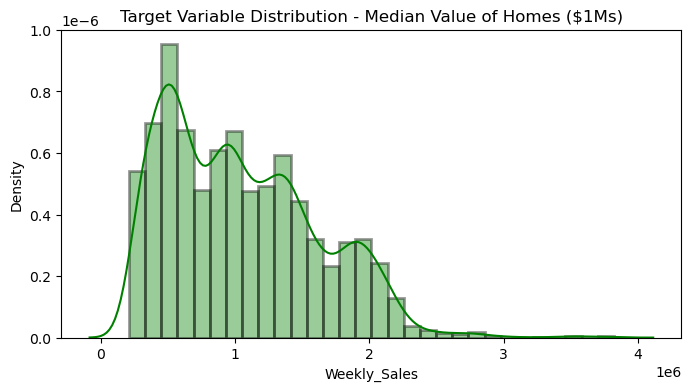

In [8]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()


In [9]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [10]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


In [13]:
df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
month
Store


(6435, 64)

In [14]:
df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,year_2011,year_2012,month_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,False,42.31,2.572,211.096358,8.106,4,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1641957.44,True,38.51,2.548,211.242170,8.106,4,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,1611968.17,False,39.93,2.514,211.289143,8.106,4,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,1409727.59,False,46.63,2.561,211.319643,8.106,4,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,1554806.68,False,46.50,2.625,211.350143,8.106,4,False,False,False,...,False,False,False,False,False,False,False,False,False,False



Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 5953 samples.


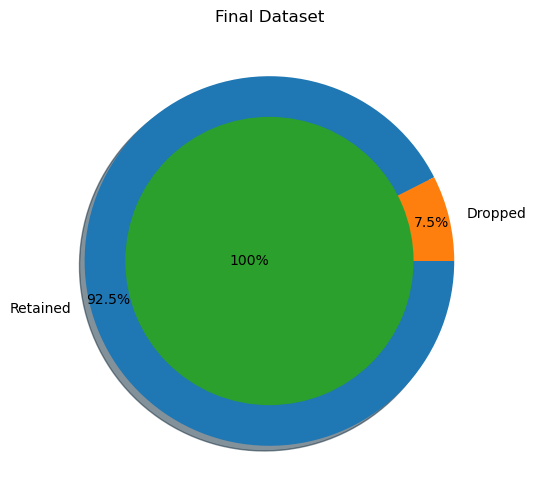


Inference: After the cleanup process, 482 samples were dropped, while retaining 7.49% of the data.


In [15]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

In [16]:
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 63) (5953,) 
Training set  --->  (4762, 63) (4762,) 
Testing set   --->  (1191, 63)  (1191,)


In [17]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,year_2011,year_2012,month_2,month_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4762.0,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,...,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03
mean,-1.492110e-18,-1.305596e-16,-2.991680e-16,-2.762268e-16,-4.267434e-16,0.0,-5.520807e-17,1.939743e-17,7.460550e-18,3.618367e-17,...,1.529413e-17,4.923963e-17,8.952659e-18,1.342899e-17,-3.730275e-18,-1.492110e-17,3.730275e-17,-2.984220e-17,-4.774752e-17,2.499284e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,0.0,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,...,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.742012e-01,-2.961575e+00,-1.871814e+00,-1.248731e+00,-2.762670e+00,0.0,-7.526270e-01,-6.371530e-01,-2.982532e-01,-3.166659e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
25%,-2.742012e-01,-7.314248e-01,-9.886990e-01,-1.076949e+00,-6.783836e-01,0.0,-7.526270e-01,-6.371530e-01,-2.982532e-01,-3.166659e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
50%,-2.742012e-01,1.062547e-01,1.663112e-01,3.842133e-01,9.596435e-02,0.0,-7.526270e-01,-6.371530e-01,-2.982532e-01,-3.166659e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
75%,-2.742012e-01,7.731979e-01,8.427860e-01,9.933828e-01,6.138095e-01,0.0,1.328679e+00,1.569482e+00,-2.982532e-01,-3.166659e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
max,3.646958e+00,2.170008e+00,2.469806e+00,1.340791e+00,2.575491e+00,0.0,1.328679e+00,1.569482e+00,3.352856e+00,3.157903e+00,...,6.356783e+00,6.300861e+00,2.298067e+01,6.328643e+00,7.650163e+00,6.503146e+00,6.356783e+00,6.141290e+00,6.443435e+00,6.564495e+00



                                          Standardardization on Testing set                                          


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,year_2011,year_2012,month_2,month_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.0,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.005646,0.044406,0.075113,0.021041,-0.050953,0.0,0.052984,0.065042,0.026699,-0.019096,...,-0.004168,-0.017693,0.111140,-0.010959,-0.000055,0.030677,-0.004168,-0.056970,0.016556,0.045053
std,1.009885,1.000220,0.971917,1.004644,1.010206,0.0,1.014188,1.028250,1.040072,0.972715,...,0.987401,0.944330,1.881448,0.965939,1.000214,1.093088,0.987401,0.810380,1.051077,1.134875
min,-0.274201,-2.857425,-1.780457,-1.248731,-2.762670,0.0,-0.752627,-0.637153,-0.298253,-0.316666,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
25%,-0.274201,-0.657516,-0.852751,-1.077025,-0.699355,0.0,-0.752627,-0.637153,-0.298253,-0.316666,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
50%,-0.274201,0.187351,0.298996,0.393492,0.058860,0.0,-0.752627,-0.637153,-0.298253,-0.316666,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
75%,-0.274201,0.818764,0.844961,1.019967,0.611390,0.0,1.328679,1.569482,-0.298253,-0.316666,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
max,3.646958,2.035481,2.469806,1.345814,2.575491,0.0,1.328679,1.569482,3.352856,3.157903,...,6.356783,6.300861,22.980668,6.328643,7.650163,6.503146,6.356783,6.141290,6.443435,6.564495


In [18]:
import pandas as pd
from statsmodels.formula.api import ols

# Concatenating scaled features and target variable into Train_xy
Train_xy = pd.concat([Train_X_std, Train_Y.reset_index(drop=True)], axis=1)

# Constructing the formula for linear regression
formula = '{} ~ {}'.format(target, ' + '.join(i for i in Train_X_std.columns))

# Fitting the linear regression model
API = ols(formula=formula, data=Train_xy).fit()

# Printing the summary of the model
print(API.summary())


                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1155.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:05:21   Log-Likelihood:                -63223.
No. Observations:                4762   AIC:                         1.266e+05
Df Residuals:                    4699   BIC:                         1.270e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.048e+06   2059.199    508.743   

Dropped Features -->  ['CPI', 'year_2012', 'Temperature', 'Unemployment', 'month_4', 'Store_30', 'month_2', 'Store_27', 'Fuel_Price', 'Store_29', 'month_7', 'Store_32', 'month_9', 'Store_8', 'Store_25', 'month_8', 'Store_43', 'Store_17', 'month_10', 'Store_18', 'Holiday_Flag', 'Store_19', 'Store_20', 'Store_16', 'Store_21', 'Store_22', 'month_3', 'Store_15', 'Store_36', 'Store_14', 'Store_45', 'Store_13', 'month_5', 'year_2011', 'month_6', 'Store_24', 'Store_26', 'Store_44', 'Store_42', 'Store_41', 'month_11', 'Store_40', 'Store_39', 'Store_11', 'Store_35', 'Store_10', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6']


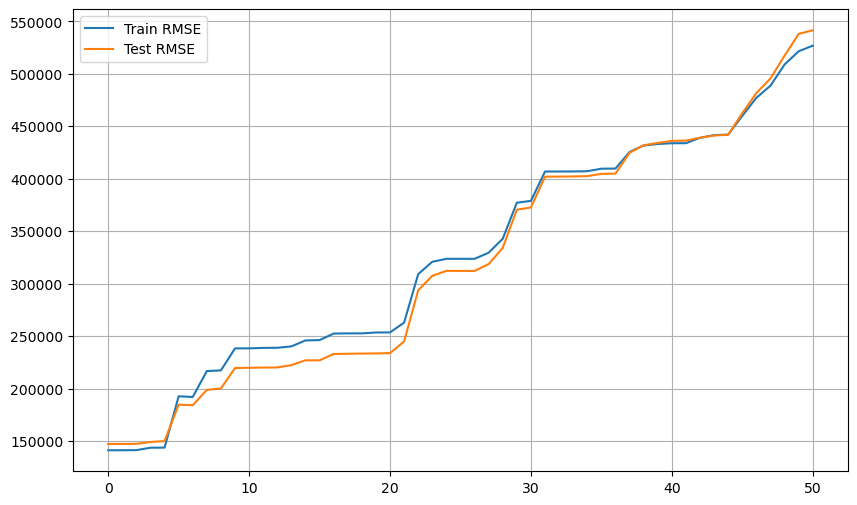

In [19]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
#Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
#Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)
        
print('Dropped Features --> ',DROP)
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

In [20]:
lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-28)             # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

150459.66166466865
155774.0243125204


In [24]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1, pred2):
    # Plotting predicted values alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e, i in enumerate(rc):
        plt.subplot(2, 3, e + 1)
        plt.scatter(y=np.maximum(Train_Y, 0), x=np.maximum(Train_X_std[i], 0), label='Actual')
        plt.scatter(y=np.maximum(pred1, 0), x=np.maximum(Train_X_std[i], 0), label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')     
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


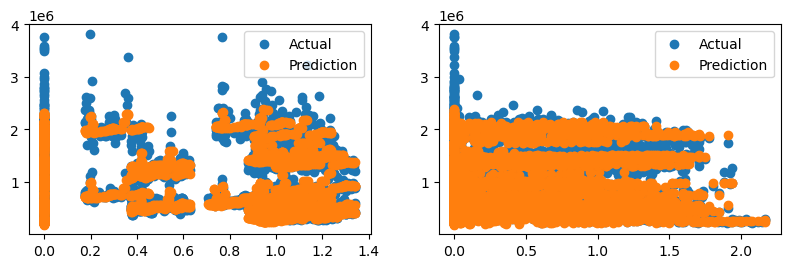



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9300498690131108
Residual Sum of Squares (RSS) on Training set  ---> 107802678811630.14
Mean Squared Error (MSE) on Training set       ---> 22638109788.246563
Root Mean Squared Error (RMSE) on Training set ---> 150459.66166466865

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9290580851277542
Residual Sum of Squares (RSS) on Training set  ---> 28900266060766.57
Mean Squared Error (MSE) on Training set       ---> 24265546650.517693
Root Mean Squared Error (RMSE) on Training set ---> 155774.0243125204

--------------------Residual Plots--------------------


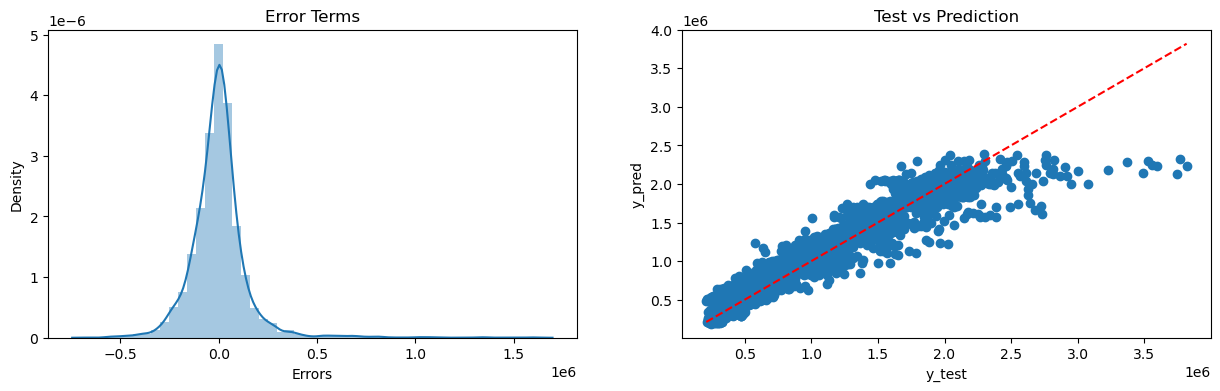

In [25]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


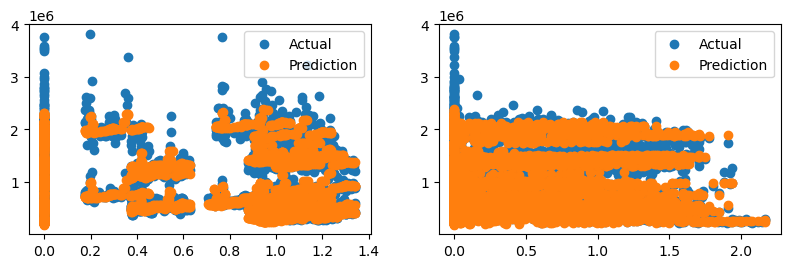



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9300496637936124
Residual Sum of Squares (RSS) on Training set  ---> 107802995082827.47
Mean Squared Error (MSE) on Training set       ---> 22638176203.86969
Root Mean Squared Error (RMSE) on Training set ---> 150459.8823735739

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9290681487441195
Residual Sum of Squares (RSS) on Training set  ---> 28896166351997.594
Mean Squared Error (MSE) on Training set       ---> 24262104409.737694
Root Mean Squared Error (RMSE) on Training set ---> 155762.97509272766

--------------------Residual Plots--------------------


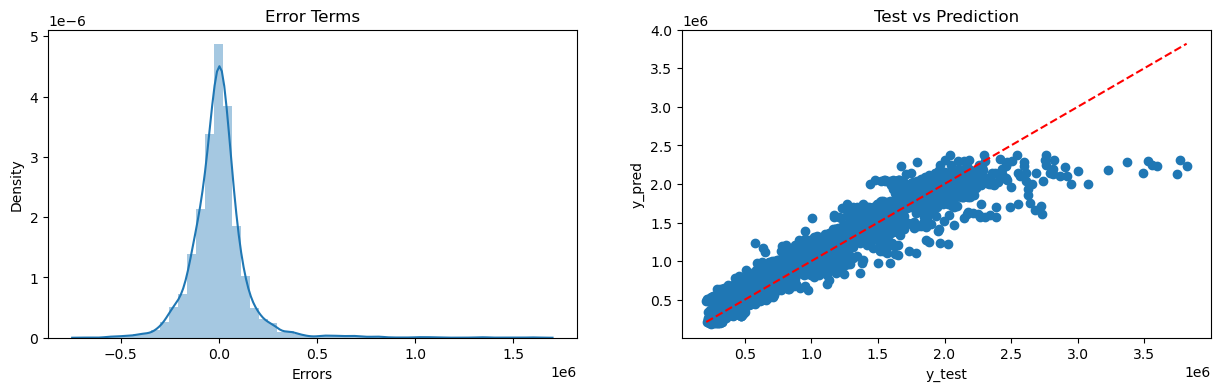

In [26]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


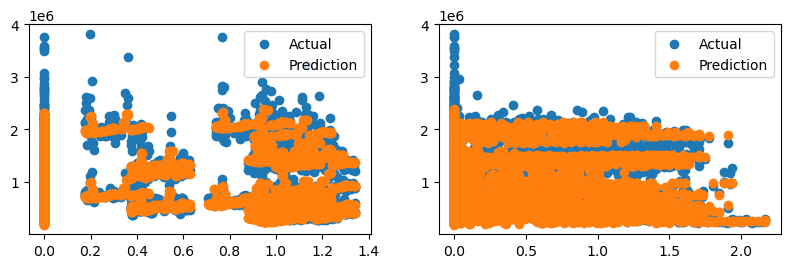



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9300498687633085
Residual Sum of Squares (RSS) on Training set  ---> 107802679196609.3
Mean Squared Error (MSE) on Training set       ---> 22638109869.090572
Root Mean Squared Error (RMSE) on Training set ---> 150459.6619333254

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9290584288786742
Residual Sum of Squares (RSS) on Training set  ---> 28900126023764.98
Mean Squared Error (MSE) on Training set       ---> 24265429071.171272
Root Mean Squared Error (RMSE) on Training set ---> 155773.64690849115

--------------------Residual Plots--------------------


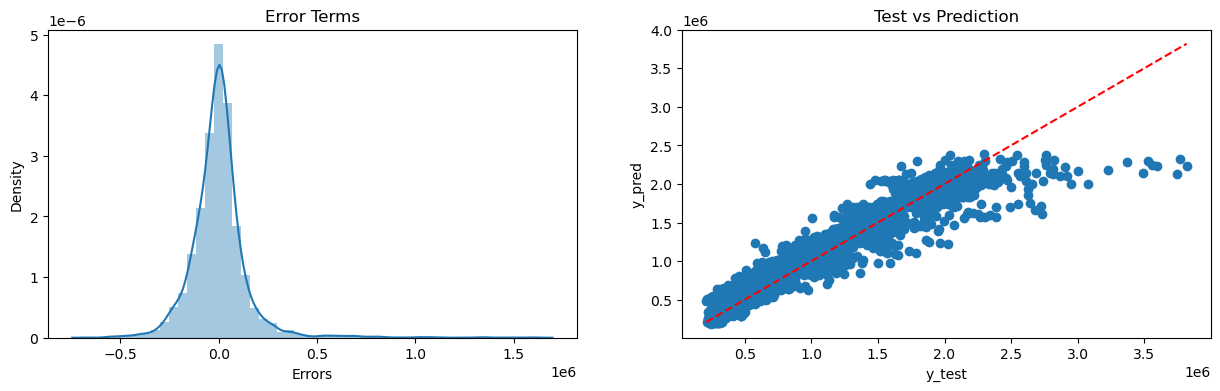

In [29]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


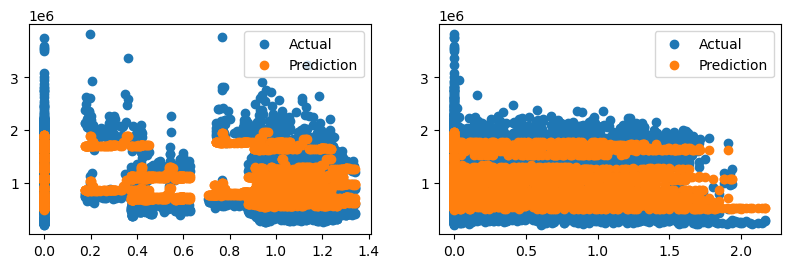



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.7871424160759006
Residual Sum of Squares (RSS) on Training set  ---> 328042527278328.9
Mean Squared Error (MSE) on Training set       ---> 68887552977.38951
Root Mean Squared Error (RMSE) on Training set ---> 262464.38420743775

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.7923376537640883
Residual Sum of Squares (RSS) on Training set  ---> 84597336677879.95
Mean Squared Error (MSE) on Training set       ---> 71030509385.28963
Root Mean Squared Error (RMSE) on Training set ---> 266515.49558194476

--------------------Residual Plots--------------------


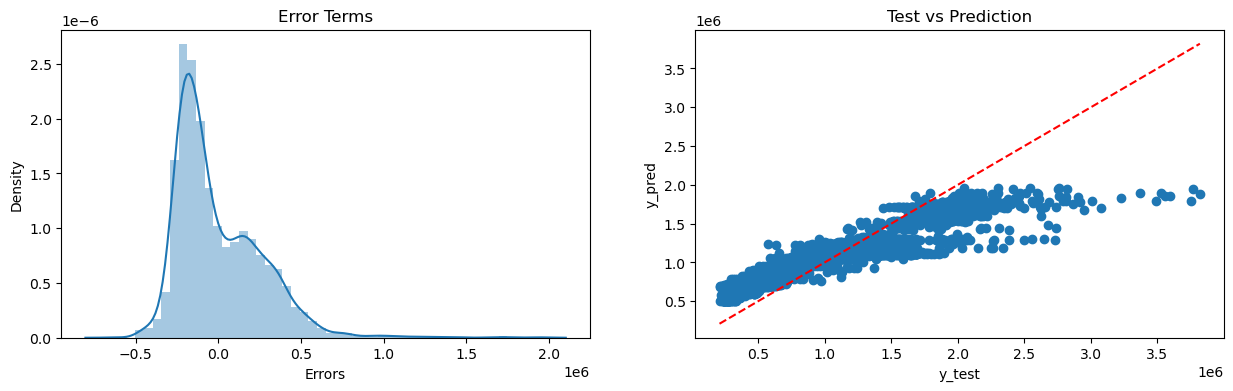

In [30]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [  20994.84559677  227390.04858906   31804.06199226   74824.11542794
   67047.30306019 -167295.37787281  158994.71000533 -169344.72504638
 -115145.31430541  -91321.19625995 -137612.2399299   138101.61019103
  -23162.67597162  158091.22199972  109994.6575779   -57057.1944685
 -124597.14379525   67904.21264383  103609.47722692 -109537.59789928
   52722.33661041   54708.75713097 -114216.82932918  118627.30850624
  -72092.52083921 -166183.27103103  -26703.18677157 -110473.39901656
 -168992.17776092 -148340.20789707  -23327.50120846  -64521.60327083
 -126739.21866619  -98607.46178895  -77491.02524189]
The Intercept of the Regresion Model was found to be  1047603.298112138


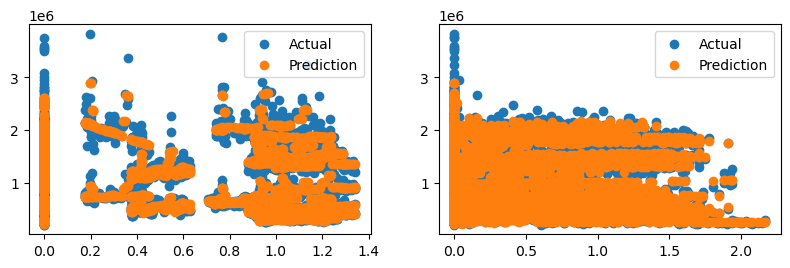



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9456453952746297
Residual Sum of Squares (RSS) on Training set  ---> 83767848787023.56
Mean Squared Error (MSE) on Training set       ---> 17590896427.3464
Root Mean Squared Error (RMSE) on Training set ---> 132630.67679592984

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9320847769101225
Residual Sum of Squares (RSS) on Training set  ---> 27667254547729.414
Mean Squared Error (MSE) on Training set       ---> 23230272500.19262
Root Mean Squared Error (RMSE) on Training set ---> 152414.80407162756

--------------------Residual Plots--------------------


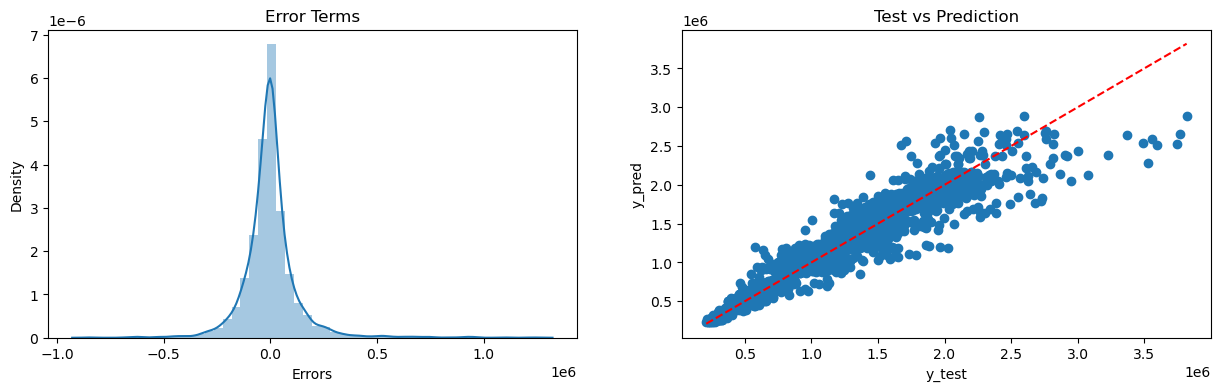

In [32]:
#Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

In [33]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC


,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.930050,0.929058,1.078027e+14,2.890027e+13,2.263811e+10,2.426555e+10,150459.661665,155774.024313
Ridge Linear Regression (RLR),0.930050,0.929068,1.078030e+14,2.889617e+13,2.263818e+10,2.426210e+10,150459.882374,155762.975093
Lasso Linear Regression (LLR),0.930050,0.929058,1.078027e+14,2.890013e+13,2.263811e+10,2.426543e+10,150459.661933,155773.646908
Elastic-Net Regression (ENR),0.787142,0.792338,3.280425e+14,8.459734e+13,6.888755e+10,7.103051e+10,262464.384207,266515.495582
Polynomial Regression (PNR),0.945645,0.932085,8.376785e+13,2.766725e+13,1.759090e+10,2.323027e+10,132630.676796,152414.804072


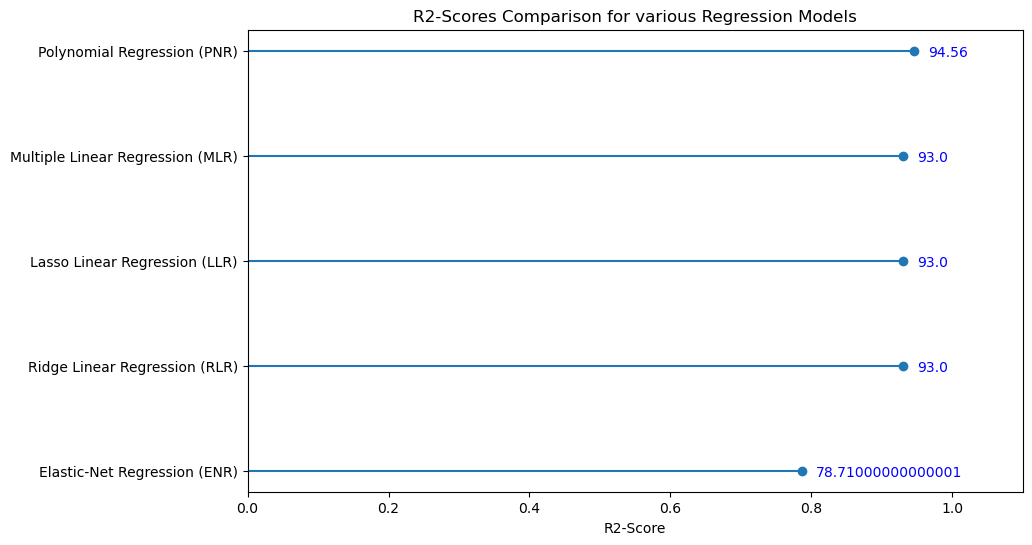

In [34]:
# R2-Scores Comparison for different Regression Models

R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()